In [46]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/dynamics-simulation-16-715/lecture-notebooks/Lecture 15/Project.toml`


In [47]:
using LinearAlgebra
using OrdinaryDiffEq
using ForwardDiff
using Plots

In [48]:
#Pendulum Parameters
ℓ = 1.0
m = 1.0
g = 9.81

9.81

In [49]:
#Reference Solution w/ODE Solver

#Classical pendulum dynamics
function f(x,p,t)
    q = x[1]
    v = x[2]
    
    v̇ = -(g/ℓ)*sin(q)
    
    ẋ = [v; v̇]
end

#initial conditions
x0 = [pi/2; 0]

#Simulate
tspan = (0.0,100.0)
prob = ODEProblem(f,x0,tspan)
sol = solve(prob,Tsit5());
#sol = solve(prob,Tsit5(),abstol=1e-5,reltol=1e-5);
#sol = solve(prob,Tsit5(),abstol=1e-6,reltol=1e-6);

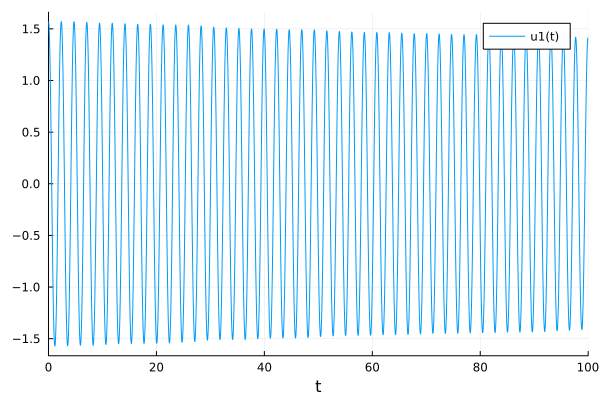

In [50]:
plot(sol,vars=(0,1))

In [51]:
#Energy Functions

function T(θ̇)
    0.5*m*ℓ*ℓ*θ̇*θ̇
end

function U(θ)
    m*g*ℓ*(1-cos(θ))
end

function H(x)
    U(x[1]) + T(x[2])
end

H (generic function with 1 method)

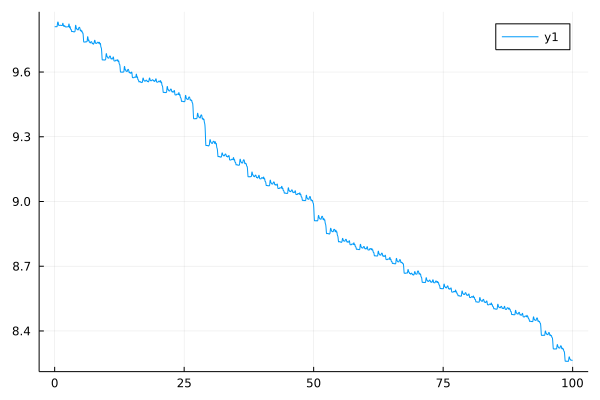

In [52]:
#Plot total energy
h = 0.01 #time step
tk = 0:h:tspan[2]

N = length(tk)
E = zeros(N)
for k = 1:N
    E[k] = H(sol(tk[k]))
end

plot(tk,E)

In [53]:
#Define discrete Lagrangian and DEL equation

function L(q,q̇)
    T(q̇) - U(q)
end

function Ld(q1,q2)
    θm = 0.5*(q1+q2)
    θ̇m = (q2-q1)/h
    return h*L(θm,θ̇m)
end

function DEL(q1,q2,q3)
    ForwardDiff.derivative(dq2->Ld(q1,dq2),q2) + ForwardDiff.derivative(dq2->Ld(dq2,q3),q2)
end

DEL (generic function with 1 method)

In [54]:
#Simulate using DEL equation

#Initial conditions taken from reference solution
q1 = sol(tk[1])[1]
q2 = sol(tk[2])[1]

qhist = zeros(length(tk))
qhist[1] = q1
qhist[2] = q2

for k = 2:(length(tk)-1)
    qhist[k+1] = qhist[k]
    r = DEL(qhist[k-1],qhist[k],qhist[k+1])
    
    #Newton's method
    while norm(r) > 1e-12
        R = ForwardDiff.derivative(dq3->DEL(qhist[k-1],qhist[k],dq3),qhist[k+1])
        qhist[k+1] = qhist[k+1] - R\r
        r = DEL(qhist[k-1],qhist[k],qhist[k+1])
    end
end

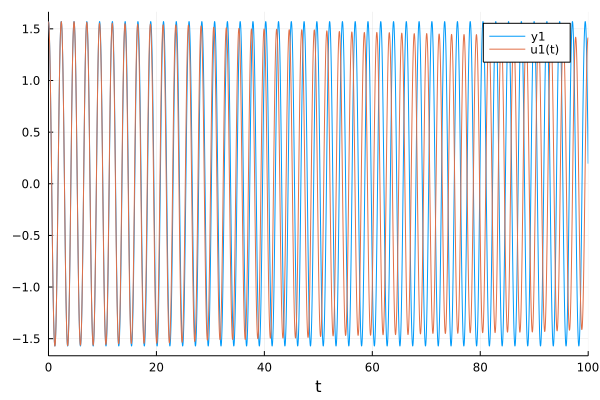

In [55]:
plot(tk,qhist)
plot!(sol,vars=(0,1))

In [56]:
#Plot total energy

function Hd(q1,q2)
    θm = 0.5*(q1+q2)
    θ̇m = (q2-q1)/h
    H([θm;θ̇m])
end

E2 = zeros(length(tk)-1)
for k = 1:(length(tk)-1)
    E2[k] = Hd(qhist[k],qhist[k+1])
end

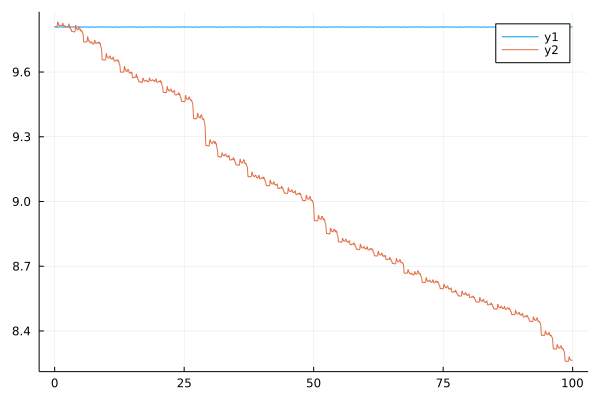

In [57]:
plot(tk[1:end-1],E2)
plot!(tk,E)